In [29]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2 # compare your method with the opencv implementation

from skimage import data

matplotlib.rcParams['font.size'] = 18

names = ['astronaut',
         'binary_blobs',
         'camera',
         'checkerboard',
         'chelsea',
         'clock',
         'coffee',
         'coins',
         'horse',
         'logo',
         'page',
         'text',
         'rocket']

images = {}
for name in names:
    caller = getattr(data, name)
    image = caller()
    images[name] = image.copy()

plt.rcParams["figure.figsize"] = (8, 6)

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Image processing

## The structure of a tensor

In [31]:
for name in images:
    img = images[name]
    print('name: ', name, ' rank: ', img.ndim, ' shape: ', img.shape, ' dtype: ', img.dtype)

name:  astronaut  rank:  3  shape:  (512, 512, 3)  dtype:  uint8
name:  binary_blobs  rank:  2  shape:  (512, 512)  dtype:  bool
name:  camera  rank:  2  shape:  (512, 512)  dtype:  uint8
name:  checkerboard  rank:  2  shape:  (200, 200)  dtype:  uint8
name:  chelsea  rank:  3  shape:  (300, 451, 3)  dtype:  uint8
name:  clock  rank:  2  shape:  (300, 400)  dtype:  uint8
name:  coffee  rank:  3  shape:  (400, 600, 3)  dtype:  uint8
name:  coins  rank:  2  shape:  (303, 384)  dtype:  uint8
name:  horse  rank:  2  shape:  (328, 400)  dtype:  bool
name:  logo  rank:  3  shape:  (500, 500, 4)  dtype:  uint8
name:  page  rank:  2  shape:  (191, 384)  dtype:  uint8
name:  text  rank:  2  shape:  (172, 448)  dtype:  uint8
name:  rocket  rank:  3  shape:  (427, 640, 3)  dtype:  uint8


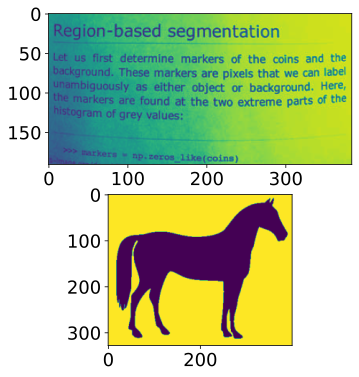

In [32]:
plt.subplot(2, 1, 1)
plt.imshow(images['page'])
plt.subplot(2, 1, 2)
plt.imshow(images['horse'])

## The different types

In [33]:
def uint8_RGB_to_float32(img):
    return img.astype(np.float32)/255.

def uint8_GRAY_to_float32(img):
    img = img.astype(np.float32)/255.
    img = np.expand_dims(img, axis=-1)
    # img = np.tile(img, (1, 1, 3))
    return img

def bool_to_float32(img):
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=-1)
    # img = np.tile(img, (1, 1, 3))
    return img

def float32_to_uint8(img):
    img = 255.*img
    return img.astype(np.uint8)

def to_float32(img):
    if img.dtype == 'uint8':
        if img.ndim == 2:
            return uint8_GRAY_to_float32(img)
        else:
            return uint8_RGB_to_float32(img)
    if img.dtype == 'bool':
        return bool_to_float32(img)

for name in images:
    img = images[name]
    img = to_float32(img)
    images[name] = img

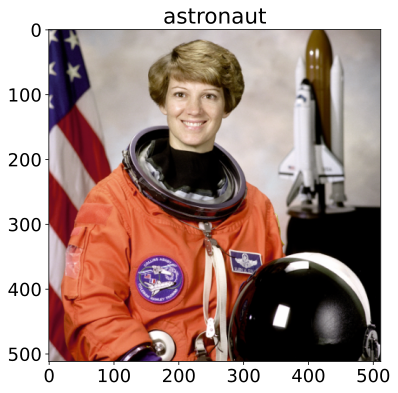

In [34]:
def imshow(img, title=''):
    plt.title(title)
    if img.ndim == 2:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        if img.shape[2] == 1:
          img = np.repeat(img, repeats=3, axis=2)
        plt.imshow(img)
    
    plt.show()

imshow(images['astronaut'], 'astronaut')

## Multi-indexing

Tensors are stored in memory as continuous one-dimensional arrays. If $ T $ is a tensor of rank 3 and of shape $(n_x, n_y, n_z)$, the index of $ T[i, j, k] $ in its one-dimensional representation is $ n_z(n_y \cdot i + j) + k $, i.e. we have $ T[i, j, k] == T[n_z(n_y \cdot i + j) + k] $. The function `numpy.reshape` described [here](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) allows changing the shape of a tensor. This operation preserves the one-dimensional indexing of the tensor but changes the way to access it via a multi-index. To convert a tensor into a one-dimensional array, you can also use the `flatten` method described [here](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html).


## Processing images

### Scaling

In [35]:
def reduce_resolution(img, k):
    conv_filter = np.array([1,1],[1,1])
    sub_shape = conv_filter.shape
    output_shape = ((img.shape[0] - sub_shape[0]) // 2 + 1, (img.shape[1] - sub_shape[1]) // 2 + 1, img.shape[2])
    strided_img = np.lib.stride_tricks.as_strided(
        img,
        shape=output_shape + sub_shape + (img.shape[2],),
        strides=(img.strides[0] * 2, img.strides[1] * 2, img.strides[2], img.strides[0], img.strides[1], img.strides[2])
    )
    reduced_img = np.tensordot(strided_img, conv_filter, axes=((3, 4), (0, 1))) / 4
    return reduced_img